# Eniac

## Importing Data

Turning them into a dictionary of dataframes.

In [1]:
import pandas as pd
import numpy as np

orders_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orders_clean.parquet"
orderlines_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orderlines_clean.parquet"
products_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/products_clean.parquet"
brands_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/brands_clean.parquet"

# Loading dataframes directly from GitHub
orders_df = pd.read_parquet(orders_url)
orderlines_df = pd.read_parquet(orderlines_url)
products_df = pd.read_parquet(products_url)
brands_df = pd.read_parquet(brands_url)

orders = orders_df.copy()
orderlines = orderlines_df.copy()
products = products_df.copy()
brands = brands_df.copy()


Keys of tables:

order_id : orders, orderlines

sku = products, orderlines, brands --> the first three letters of sku = short brand name

Questions:

What is id: and unit_price: in orderlines?

What is total_paid in orders? What is created_date in orders?

## Data Integration

In [2]:
# Rename column to match with orders (better readability)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)

In [3]:
orderlines['short_brand'] = orderlines['sku'].str[:3]

In [4]:
# Merge Orderlines on brands, since both tables are small anyway
orderlines_brands = orderlines.merge(brands, left_on='short_brand' ,right_on='short', how='left')

In [5]:
oo = orders.merge(orderlines, on='order_id', how='left')
boo = oo.merge(brands, left_on ='short_brand', right_on='short', how='left')
boop = boo.merge(products, on ='sku', how='left')

In [6]:
# Let's say you want to drop the columns 'column_name1', 'column_name2', and 'column_name3'
boop.drop(columns=['short'], inplace=True)

- DataFrame **.describe()** gives basic numerical aggregations. It can be applied to a single column as well.
- DataFrame **.isna().any()** highlights which columns contain missing data
- DataFrame **.shape** gives the number of rows and columns
- DataFrame **.columns** gives the column names. Note that a list with new names can be passed to this attribute to rename the columns.
- DataFrame **.columnName.isna().sum()** is a quick way to check the number of missing values in a column
- DataFrame **.columnName.value_counts()** is a great way to summarise a categorical column. You can use it to discover how many orders are completed, cancelled, pending…
- DataFrame **.columnName.hist()** is an easy way to plot a histogram in a numerical column. Play with the bins argument to change the granularity of the graph.

## Create a new column with the Promo Price

In [7]:
boop['is_promo'] = boop['unit_price'] < boop['price']
boop['estimated_promo_price'] = boop.apply(lambda row: row['unit_price'] if row['is_promo'] else np.nan, axis=1)
boop[['estimated_promo_price','is_promo', 'promo_price', 'price']]

,estimated_promo_price,is_promo,promo_price,price
0,44.99,True,42.99,49.95
1,129.16,True,114.99,139.99
2,10.77,True,10.99,17.99
3,77.99,True,99.99,99.99
4,51.29,True,58.99,59.95
...,...,...,...,...
315951,42.99,True,42.99,49.95
315952,42.99,True,42.99,49.95
315953,141.58,True,141.58,215.98
315954,9.99,True,9.99,25.00


## Step 2: Analyzing Order Patterns in Relation to Discounts

Objective:
To understand if the introduction or availability of discounts affects order patterns – both in terms of quantity and frequency.

### 1. Understand basic metrics

In [8]:
total_orders = boop['order_id'].nunique()
avg_order_value = boop.groupby('order_id')['total_paid'].first().mean()
avg_items_per_order = boop.groupby('order_id').size().mean()

In [9]:
print(total_orders)
print(avg_order_value)
print(avg_items_per_order)

226904
569.2258182755703
1.3924655360857454


### 2. Segment Orders by Discounts:

In [10]:
orders_with_discount = boop.groupby('order_id')['is_promo'].any()
orders_with_discount

order_id
241319    True
241423    True
242832    True
243330    True
243784    True
          ... 
527397    True
527398    True
527399    True
527400    True
527401    True
Name: is_promo, Length: 226904, dtype: bool

### 3. Compare Metrics

In [11]:
avg_order_value_discounted = boop[boop['is_promo']].groupby('order_id')['total_paid'].first().mean().round(2)
avg_order_value_non_discounted = boop[~boop['is_promo']].groupby('order_id')['total_paid'].first().mean().round(2)

avg_items_discounted = boop[boop['is_promo']].groupby('order_id').size().mean().round(2)
avg_items_non_discounted = boop[~boop['is_promo']].groupby('order_id').size().mean().round(2)
print(avg_order_value_discounted)
print(avg_order_value_non_discounted)
print(avg_items_discounted)
print(avg_items_non_discounted)

656.86
497.58
1.4
1.05


### 4. Temporal Analysis

In [12]:
boop.dtypes

order_id                         object
created_date             datetime64[ns]
total_paid                      float64
state                          category
product_quantity                float64
sku                              object
unit_price                      float64
date                     datetime64[ns]
short_brand                      object
long                             object
name                             object
desc                             object
price                           float64
promo_price                     float64
in_stock                         object
type                           category
promo_percentage                float64
is_promo                           bool
estimated_promo_price           float64
dtype: object

In [13]:
boop['created_month'] = boop['created_date'].dt.month
monthly_discounted_orders = boop[boop['is_promo']].groupby('created_month').size()
monthly_discounted_orders

created_month
1     54390
2     32723
3     21435
4      9713
5      9342
6      9487
7     14036
8     10068
9     11630
10    13969
11    40066
12    32027
dtype: int64

### 5. Visiual Analysis

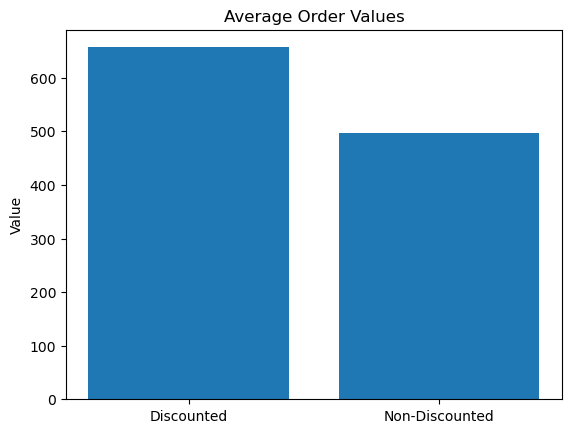

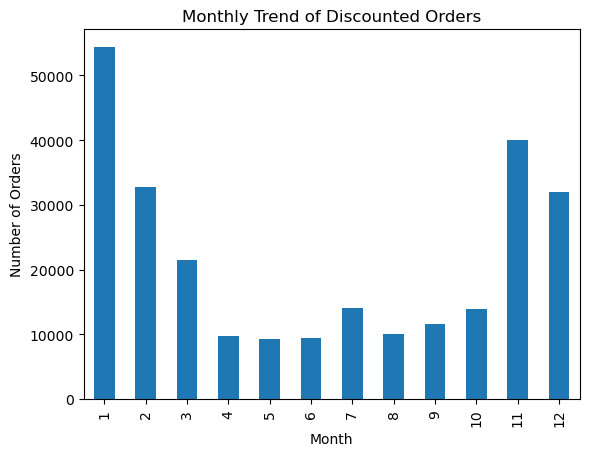

In [14]:
import matplotlib.pyplot as plt

# Average order values comparison
plt.bar(['Discounted', 'Non-Discounted'], [avg_order_value_discounted, avg_order_value_non_discounted])
plt.title('Average Order Values')
plt.ylabel('Value')
plt.show()

# Monthly trends of discounted orders
monthly_discounted_orders.plot(kind='bar')
plt.title('Monthly Trend of Discounted Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Month')
plt.show()


Possible Conclusions:

- If orders with discounts have a significantly higher average value or quantity, it suggests discounts might be driving larger orders.
- If there's a temporal trend showing increased discount orders during specific times, it might suggest seasonal trends or the effects of periodic discount campaigns.

## Step 3: Analyzing Customer Behavior and Retention with Respect to Discounts:

### 1. Retention Rate with Respect to Discounts:

In [15]:
boop

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short_brand,long,name,desc,price,promo_price,in_stock,type,promo_percentage,is_promo,estimated_promo_price,created_month
0,241319,2017-01-02 13:35:40,44.99,Cancelled,1.0,JBL0123,44.99,2017-01-02 12:26:59,JBL,JBL,JBL T450 Bluetooth BT Headset White,Wireless headphones with folding design with 1...,49.95,42.99,True,5384,0.1393,True,44.99,1
1,241423,2017-11-06 13:10:02,136.15,Completed,1.0,LAC0212,129.16,2017-11-06 12:47:20,LAC,LaCie,LaCie Porsche Design Desktop Drive 4TB USB 3.0...,External Hard Drive 4TB 35-inch USB 3.0 for Ma...,139.99,114.99,True,11935397,0.1786,True,129.16,11
2,242832,2017-12-31 17:40:03,15.76,Completed,1.0,PAR0074,10.77,2017-12-31 17:26:40,PAR,Parrot,Parrot 550mAh battery for MiniDrones,550mAh rechargeable battery for Parrot minidrones,17.99,10.99,False,11905404,0.3891,True,10.77,12
3,243330,2017-02-16 10:59:38,84.98,Completed,1.0,OWC0074,77.99,2017-02-15 17:07:44,OWC,OWC,Mac OWC Memory 8GB 1066MHZ DDR3 SO-DIMM,8GB RAM Mac mini iMac MacBook and MacBook Pro ...,99.99,99.99,True,1364,0.0000,True,77.99,2
4,243784,2017-11-24 13:35:19,157.86,Cancelled,3.0,PHI0080,51.29,2017-11-24 13:27:41,PHI,Philips,Philips HUE White Ambience Pack 2 GU10 bulbs,Pack of two bulbs with different shades of whi...,59.95,58.99,True,11905404,0.0160,True,51.29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315951,527397,2018-03-14 13:56:38,42.99,Place Order,1.0,JBL0122,42.99,2018-03-14 13:56:38,JBL,JBL,JBL T450 BT Bluetooth Headset Black,Wireless headphones with folding design with 1...,49.95,42.99,True,5384,0.1393,True,42.99,3
315952,527398,2018-03-14 13:57:25,42.99,Shopping Basket,1.0,JBL0122,42.99,2018-03-14 13:57:25,JBL,JBL,JBL T450 BT Bluetooth Headset Black,Wireless headphones with folding design with 1...,49.95,42.99,True,5384,0.1393,True,42.99,3
315953,527399,2018-03-14 13:57:34,141.58,Shopping Basket,1.0,PAC0653,141.58,2018-03-14 13:57:34,PAC,Pack,Samsung SSD 850 expansion kit EVO 250GB + Data...,SSD upgrade kit 2008-2010 250 GB MacBook and M...,215.98,141.58,True,1433,0.3445,True,141.58,3
315954,527400,2018-03-14 13:57:41,19.98,Shopping Basket,2.0,APP0698,9.99,2018-03-14 13:57:41,APP,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,9.99,True,1230,0.6004,True,9.99,3
